In [1]:
import joblib
import numpy as np
import sys
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import gettempdir
import seaborn as sns
from Bio import PDB
from Bio.PDB.DSSP import DSSP
from Bio.PDB import NeighborSearch
from Bio import SeqIO
from Bio.PDB import PDBList
import Bio.PDB.Polypeptide as Polypeptide
import itertools
from math import sqrt
import sklearn.metrics as metrics
from scipy.stats import pearsonr
import pprint
import os
import gzip
from sultan import Sultan
from retrieve_pdb import retrieve_pdb_file
import cmap
import tempfile
from biotite.application.dssp import DsspApp


In [2]:
trrosetta= np.load('/home/fapatalano/Desktop/tesi/distpred/1a64.npz')
pdb_code= "1a64".upper()
pdbfile= f'/home/fapatalano/Desktop/tesi/dataset/pdb_file/{pdb_code}.pdb'

In [3]:
def get_pdb_coord(pdbfile, pdb_code):
    """

    :param pdbfile:
    :param pdb_code:
    :return: coords:
             list for each chain of residues in the PDB file without Hetero atoms
    """
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb_code, pdbfile)
    chains= PDB.Selection.unfold_entities(structure[0], 'C')
    coords = [PDB.Selection.unfold_entities(chains[0], 'R'),PDB.Selection.unfold_entities(chains[1], 'R')]
    return coords

pdb_coord=get_pdb_coord(pdbfile, pdb_code)

,ss,RSA
0,-,0.940476
1,E,0.542254
2,E,0.260563
3,E,0.616740
4,E,0.119048
...,...,...
89,E,0.006098
90,E,0.516129
91,E,0.130178
92,E,0.634146


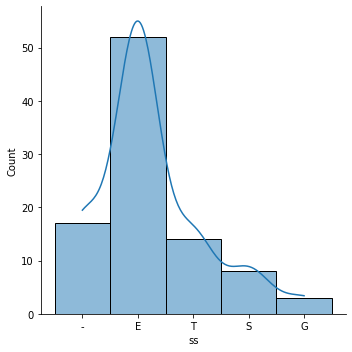

In [28]:
def get_ss_structure(pdbfile,pdb_code):
    lcDict= {'ss':[],'RSA':[]}
    structure = PDB.PDBParser().get_structure(pdb_code, pdbfile)
    model = structure[0]
    dssp = DSSP(model, pdbfile)
    a_key = list(dssp.keys())
    for a in a_key:
        if a[0] == 'A':
            lcDict['ss'] += dssp[a][2]
            lcDict['RSA'].append(dssp[a][3])
    df_ss= pd.DataFrame.from_dict(lcDict)
    return df_ss

df_ss =get_ss_structure(pdbfile,pdb_code)
sns.displot(df_ss['ss'],kde=True)
df_ss

In [5]:
def trrosetta2maps(trrosetta, probcut=0.5, bin_step=0.5):

    """
    :param trrosetta:
    :param probcut:
    :param bin_step:
    :return:
    """

    a = trrosetta['dist']
    bins = np.array([2.25 + bin_step * i for i in range(36)])
    if len(a[0, 0, :]) != 37:
        raise Exception('ERROR! This is not a trRosetta prediction')
    D = np.full((len(a), len(a)), 20.0)  # res
    np.fill_diagonal(D, 0)
    for i in range(len(a)):
        for j in range(len(a[0])):
            maxprob_value = np.sum(a[i, j, 5:], axis=-1)
            if maxprob_value > probcut:
                D_slice = a[i, j, 1:]
                mean_dist = np.sum(np.multiply(bins, D_slice / np.sum(D_slice)))
                D[i, j] = mean_dist
    return D

def pdb2dmap(chains):
    """
    :param chains:
           list for each chain of residues in the PDB file without hetatom
    :return: pdb_map:
             numpy array filled with the true intrachain and interchain distances
    """

    residues_tot = chains[0] + chains[1]
    L = len(chains[0]) * 2
    pdb_map = np.full((L, L), np.nan)
    for i in residues_tot:
        for j in residues_tot:
            if i.resname == 'GLY' and j.resname == 'GLY':
                if i.has_id('CA') and j.has_id('CA') and i.id[1] - 1 < L and j.id[1] - 1 < L:
                    pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CA"] - j["CA"]
            elif i.resname == 'GLY' and j.has_id('CB'):
                if i.has_id('CA') and i.id[1] - 1 < L and j.id[1] - 1 < L: pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CA"] - j["CB"]
            elif j.resname == 'GLY' and i.has_id('CB'):
                if j.has_id('CA') and i.id[1] - 1 < L and j.id[1] - 1 < L: pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CB"] - j["CA"]
            elif i.has_id('CB') and j.has_id('CB') and i.id[1] - 1 < L and j.id[1] - 1 < L: pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CB"] - j["CB"]
    # pdb_map[pdb_map > 20] = np.nan
    return pdb_map


pdb_map = pdb2dmap(pdb_coord)
trrosetta_map = trrosetta2maps(trrosetta)
tot_pred_intra_distances = trrosetta_map.flatten().tolist()

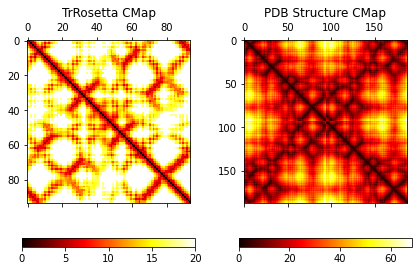

In [6]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
plot1 = ax1.matshow(trrosetta_map, cmap="hot")
plot2 = ax2.matshow(pdb_map, cmap="hot")
ax1.title.set_text('TrRosetta CMap')
ax2.title.set_text('PDB Structure CMap')
fig.colorbar(plot1, ax=ax1, orientation='horizontal')
fig.colorbar(plot2, ax=ax2, orientation='horizontal')
fig.tight_layout()


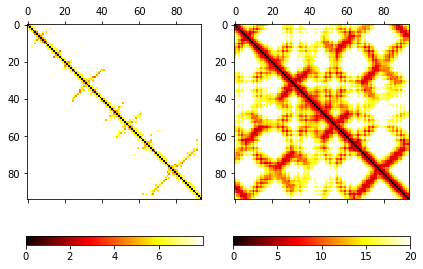

In [8]:
def get_true_intrachain_dist(pdb_cmap,coords):
    """
    :param pdb_cmap:
            PDB coordinates
    :return: distances: intra-chain distances obtained from the PDB file
        Intrachain contact between two residues i and j is said to exist if the Euclidean distance between the respective C beta
        (C alpha for glycine) atoms of residues i and j is less than or equal to 12.0 Å --> uguzzoni et al
    """

    L = len(coords[0])
    distance_matrix = pdb_cmap[:L, :L]
    distance_matrix[distance_matrix > 8] = np.nan
    return distance_matrix

true_intra_map = get_true_intrachain_dist(pdb_map,pdb_coord)

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
plot1 = ax1.matshow(true_intra_map, cmap="hot")
plot2 = ax2.matshow(trrosetta_map, cmap="hot")
fig.colorbar(plot1, ax=ax1,orientation='horizontal')
fig.colorbar(plot2, ax=ax2,orientation='horizontal')
fig.tight_layout()

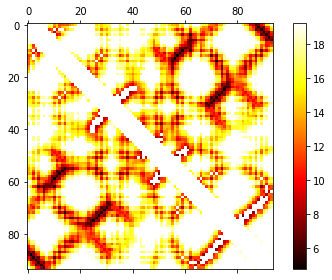

In [9]:
def filter_contact(predicted_map, true_intrachain_c):
    """
    :param predicted_map: predicted contact map
    :param true_intrachain_c:
    :return: filtered_dist

    filter contact removing the matching true intrachain contact and remove contact with a
    sequence distance lower than 6
    """
    seq_dist = 6
    true_contact = np.where(~np.isnan(true_intrachain_c))
    listOfCoordinates = list(zip(true_contact[0], true_contact[1]))
    # Short sequence separation
    for row in range(len(predicted_map)):
        i = 0 if (row - seq_dist + 1) < 0 else row - seq_dist + 1
        j = row + seq_dist if (row + seq_dist) <= (len(predicted_map)) else (len(predicted_map))
        predicted_map[row, i:j] = np.nan
    # remove matching true contacts
    for coord in listOfCoordinates:
        if coord[0] < len(predicted_map) and coord[1] < len(predicted_map): predicted_map[coord] = np.nan
    predicted_map[predicted_map == 20] = np.nan
    return predicted_map


filtered_map = filter_contact(trrosetta_map,true_intra_map)
tot_pred_inter_distances = filtered_map.flatten().tolist()
fig,(ax1) = plt.subplots(ncols=1)
plot1 = ax1.matshow(filtered_map, cmap="hot")
fig.colorbar(plot1, ax=ax1)
fig.tight_layout()

In [10]:
def get_interacting_residues(model, r_cutoff=6):
    """
    Return residue-residue interactions between all chains in the model.

    Parameters
    ----------
    :param r_cutoff:
    :param model:

    Returns
    -------
    dict
        A dictionary of interactions between chains i (0..n-1) and j (i+1..n).
        Keys are (chain_idx, chain_id, residue_idx, residue_resnum, residue_amino_acid) tuples.
        (e.g. (0, 'A', 0, '0', 'M'), (0, 1, '2', 'K'), ...)
        Values are a list of tuples having the same format as the keys.

    Examples
    --------
    You can reverse the order of keys and values like this::

        complement = dict()
        for key, values in get_interacting_chains(model):
            for value in values:
                complement.setdefault(value, set()).add(key)


    You can get a list of all interacting chains using this command::

        {(key[0], value[0])
         for (key, values) in get_interacting_chains(model).items()
         for value in values}


    """
    interactions_between_chains = dict()
    atoms_c2 = PDB.Selection.unfold_entities(model[1], 'A')
    ns = PDB.NeighborSearch(atoms_c2)

    # Residue 1
    for residue_1 in model[0]:
        interacting_residues = set()
        for atom_1 in residue_1: interacting_residues.update(ns.search(atom_1.get_coord(), r_cutoff, 'R'))
        # ns search return a list of atoms at distance x from the target atom

        # Residue 2
        interacting_residue_ids = []
        for residue_2 in interacting_residues:
            interacting_residue_ids.append(residue_2)
            if interacting_residue_ids:
                interactions_between_chains.setdefault(residue_1, set()).update(interacting_residue_ids)
    return interactions_between_chains

interacting_residue = get_interacting_residues(pdb_coord, r_cutoff=6)
pprint.pprint(interacting_residue)

{<Residue GLY het=  resseq=1 icode= >: {<Residue ALA het=  resseq=181 icode= >,
                                        <Residue LEU het=  resseq=182 icode= >,
                                        <Residue ASP het=  resseq=183 icode= >,
                                        <Residue LEU het=  resseq=184 icode= >},
 <Residue THR het=  resseq=2 icode= >: {<Residue LEU het=  resseq=182 icode= >,
                                        <Residue ASP het=  resseq=183 icode= >,
                                        <Residue LEU het=  resseq=184 icode= >,
                                        <Residue ARG het=  resseq=185 icode= >},
 <Residue VAL het=  resseq=3 icode= >: {<Residue LEU het=  resseq=182 icode= >,
                                        <Residue ASP het=  resseq=183 icode= >,
                                        <Residue LEU het=  resseq=184 icode= >,
                                        <Residue ARG het=  resseq=185 icode= >,
                                      

Total number of interchain contacts 399


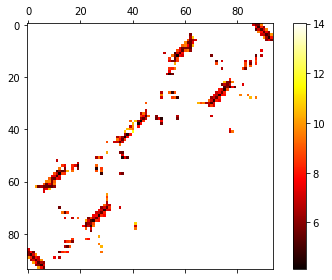

In [11]:
def get_true_inter_distances(interactions_between_chains, coords):
    """
    :param coords:
    :param interactions_between_chains:
    :return: inter
    """
    L = len(coords[0])
    inter = np.full((L,L), np.nan)
    for key, values in interactions_between_chains.items():
        for value in values:
            if key.resname == 'GLY' and value.resname == 'GLY':
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CA'] - value['CA']
            elif key.resname == 'GLY' and value.has_id('CB'):
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CA'] - value['CB']
            elif value.resname == 'GLY' and key.has_id('CB'):
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CB'] - value['CA']
            elif key.has_id('CB') and value.has_id('CB'):
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CB'] - value['CB']

    return inter
inter_distances = get_true_inter_distances(interacting_residue,pdb_coord)
print('Total number of interchain contacts',len(np.where(~np.isnan(inter_distances))[0]))
fig,(ax1) = plt.subplots(ncols=1)
plot1 = ax1.matshow(inter_distances, cmap="hot")
fig.colorbar(plot1, ax=ax1)
fig.tight_layout()

In [29]:
L = pdb_map.shape[0]//2
tot_true_intra_distances = pdb_map[:L,:L].flatten().tolist()

In [14]:
def calc_ppv(tot_pred_inter_distances,tot_true_inter_distances,n=0):
    TP=0
    FP=0
    TN=0
    FN=0
    padded_true_interd = np.pad(tot_true_inter_distances,((n,n),(n,n)),'constant',constant_values=np.nan)
    predicted_contact = np.where(~np.isnan(tot_pred_inter_distances) & (tot_pred_inter_distances!=20))
    predicted_non_contact = np.where(np.isnan(tot_pred_inter_distances) | (tot_pred_inter_distances==20) )
    for pred_cont_coord in zip(predicted_contact[0],predicted_contact[1]) :
        if not np.isnan(padded_true_interd[pred_cont_coord]): TP += 1
        elif np.isnan(padded_true_interd[pred_cont_coord]): FP += 1
        else: print(tot_true_inter_distances[pred_cont_coord],padded_true_interd[pred_cont_coord])
    for pred_non_cont_coord in zip(predicted_non_contact[0],predicted_non_contact[1]) :
        if np.isnan(padded_true_interd[pred_non_cont_coord]) : TN += 1
        elif not np.isnan(padded_true_interd[pred_non_cont_coord]): FN += 1
        else: print(tot_true_inter_distances[pred_non_cont_coord],padded_true_interd[pred_non_cont_coord])
    ppv= TP/(TP+FP)
    print(TP,FP,TN,FN,ppv)
    # for pred in np.nditer(tot_pred_inter_distances):
    #     for true in np.nditer(tot_true_inter_distances):
    #         if pred !=20 and not np.isnan(pred) and not np.isnan(true) : TP += 1
    # print(TP)
    #     elif pred !=20 and not np.isnan(pred) and np.isnan(true) : FP += 1
    #     elif (pred == 20 or np.isnan(pred)) and np.isnan(true) : TN += 1
    #     elif (pred == 20 or np.isnan(pred)) and not np.isnan(true) : FN += 1
    # print(TP,FP,TN,FN)
    # ppv= TP/(TP+FP)
    # return ppv

calc_ppv(filtered_map,inter_distances)

379 4423 4014 20 0.07892544773011245


In [15]:
tot_true_inter_distances = inter_distances.flatten().tolist()
data = {'tot_true_intra_distances': tot_true_intra_distances, 'tot_true_inter_distances': tot_true_inter_distances,'tot_pred_inter_distances':tot_pred_inter_distances,'tot_pred_intra_distances':tot_pred_intra_distances }
df= pd.DataFrame.from_dict(data)
df

,tot_true_intra_distances,tot_true_inter_distances,tot_pred_inter_distances,tot_pred_intra_distances
0,0.000000,NaN,NaN,0.000000
1,4.735469,NaN,NaN,5.525078
2,6.919489,NaN,NaN,7.108308
3,NaN,NaN,NaN,10.434892
4,NaN,NaN,NaN,13.128506
...,...,...,...,...
8831,NaN,NaN,NaN,13.560710
8832,NaN,NaN,NaN,10.533399
8833,6.750763,NaN,NaN,7.132086
8834,5.803684,NaN,NaN,5.646140


/home/fapatalano/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'ec', 'fc', 's', 'linewidth'
  **contour_kws,
/home/fapatalano/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


<AxesSubplot:xlabel='Density', ylabel='tot_true_inter_distances'>

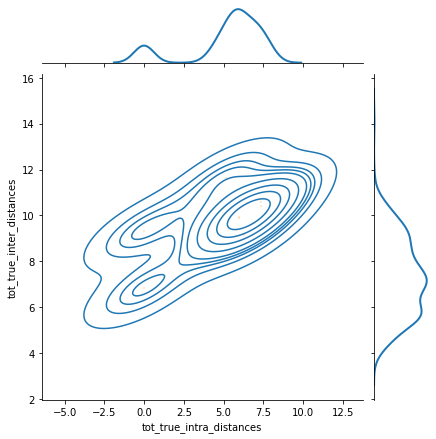

In [16]:
g = sns.JointGrid()
x, y = df["tot_true_intra_distances"], df["tot_true_inter_distances"]
sns.kdeplot(x=x, y=y, ec="b", fc="none", s=100, linewidth=1.5, ax=g.ax_joint)
sns.scatterplot(x=x, y=y, marker="+",s=5,color='darkorange', ax=g.ax_joint)
sns.kdeplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)

/home/fapatalano/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


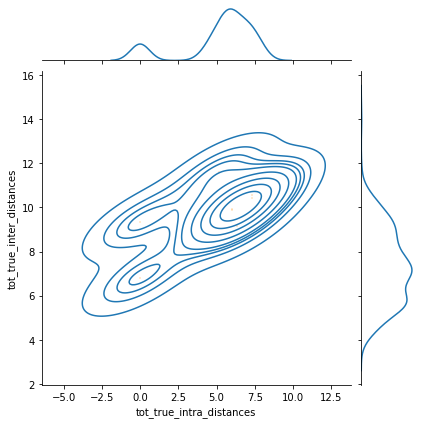

In [17]:
g = sns.jointplot(data=df, x='tot_true_intra_distances', y='tot_true_inter_distances',kind="kde")
g.plot_joint(sns.scatterplot,marker="+",s=5,color='darkorange')

/home/fapatalano/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


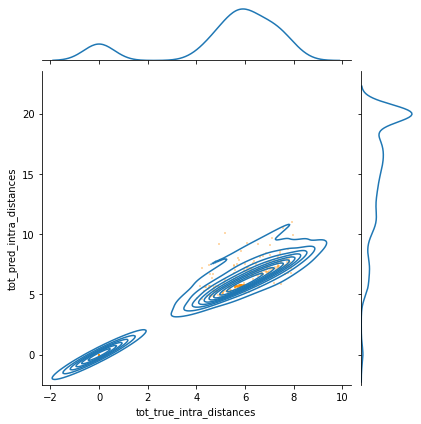

In [18]:
g = sns.jointplot(data=df, x='tot_true_intra_distances', y='tot_pred_intra_distances',kind="kde")
g.plot_joint(sns.scatterplot,marker="+",s=5,color='darkorange')

/home/fapatalano/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


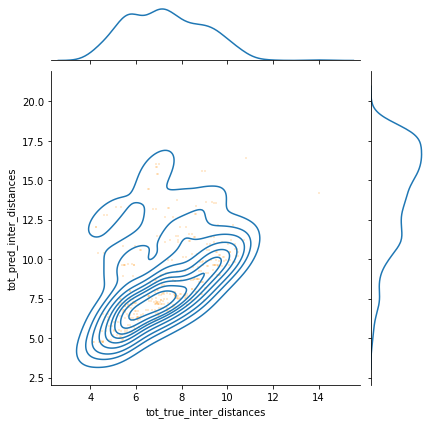

In [19]:
g = sns.jointplot(data=df, x='tot_true_inter_distances', y='tot_pred_inter_distances',kind="kde")
g.plot_joint(sns.scatterplot,marker="+",s=5,color='darkorange')


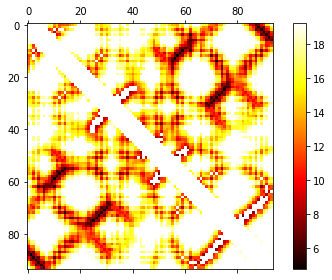

In [20]:
def relax_removal(filtered_dist, intra_dist_pdb, n):
    """
    :param filtered_dist:
           a numpy array containing filtered inter-residue distances
    :param intra_dist_pdb:
           numpy array filled with the real intra-chain distances obtained from the pdb file
    :param n:
           relax parameter it could range from 0 to 2
    :return:  relax_removal
            If position (i,j) is a true intrachain contact, and the relax parameter is n (where, n=0, 1, and 2),
            then let X = [i-n,i+n] and Y= [j-n, j+n]. Remove all contacts (Xp,Yq) from the predicted contact map where Xp={i-n, i-n+1, ..., i+n} and
            Yq={j-n, j-n+1, ..., j+n}. This removes (sets to zero) a square matrix of dimension n x n centered at (i,j) from the predicted intrachain contact map
    """
    relaxed_dmatrix = np.pad(filtered_dist, ((n, n), (n, n)), 'constant', constant_values=np.nan)
    true_contact= np.where(~np.isnan(intra_dist_pdb))
    listOfCoordinates= list(zip(true_contact[0], true_contact[1]))
    for coord in listOfCoordinates:
        i = coord[0]
        j = coord[1]
        relaxed_dmatrix[i - n:i + n + 1, j - n:j + n + 1] = np.nan
    if n != 0:
        return relaxed_dmatrix[n:-n, n:-n]
    else:
        return relaxed_dmatrix

relax_removal_map = relax_removal(filtered_map, true_intra_map, n=0)
fig,(ax1) = plt.subplots(ncols=1)
plot1 = ax1.matshow(relax_removal_map, cmap="hot")
fig.colorbar(plot1, ax=ax1)
fig.tight_layout()

In [21]:
def relaxation(true_value,prediction,n=0) :
    """

    :param true_value:
    :param prediction:
    :param n: relax parameter
    :return:
    """

    if np.isnan(true_value).all(): raise Exception('ValueError')

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    padded_true_interd = np.pad(true_value,((n,n),(n,n)),'constant',constant_values=np.nan)
    predicted_contact = np.where(~np.isnan(prediction))
    predicted_non_contact = np.where(np.isnan(prediction))
    for pred_cont_coord in zip(predicted_contact[0],predicted_contact[1]) :
        if not np.isnan(padded_true_interd[pred_cont_coord[0] :pred_cont_coord[0] + (2 * n + 1),
                        pred_cont_coord[1] :pred_cont_coord[1] + (2 * n + 1)]).all() :
            TP += 1
        elif np.isnan(padded_true_interd[pred_cont_coord]) :
            FP += 1
    for pred_non_cont_coord in zip(predicted_non_contact[0],predicted_non_contact[1]) :
        if np.isnan(padded_true_interd[pred_non_cont_coord]) :
            TN += 1
        elif not np.isnan(padded_true_interd[pred_non_cont_coord]) :
            FN += 1

    return TP,TN,FP,FN

relaxation(inter_distances,relax_removal_map)


(379, 4014, 4423, 20)